In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch
import matplotlib.ticker as mtick
import math

In [2]:
# multiplies the inner radius for easier viewing
inner_radius_modify = 1.3
inner_text_radius = 1.1

# colors

palette = 'orangeblue'
if palette is "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette is "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

if palette is 'blue':
    small_palette = [
        'mediumaquamarine',
        'royalblue',
        'mediumpurple'
    ]
elif palette is 'orangeblue':
    small_palette = [
        '#006373',
        '#E8891D',
        '#219ebc',
#         '#05A3A4',
        #'#EA652C'
    ]

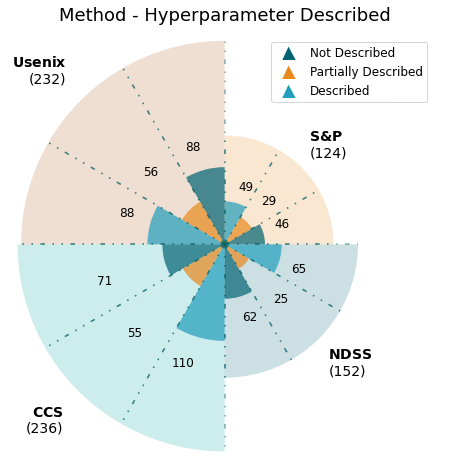

In [3]:
###### FIGURE 2 #######


### Polar Coordinate ###
df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df['Hyperparameters'].isna()]
df['Hyperparameters'] = df['Hyperparameters'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette is "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette is "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices 
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    return x
df_temp = df.copy()
df_temp["Hyperparameters"] = df_temp["Hyperparameters"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Hyperparameters"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique()) 
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2

small_colors = np.tile(small_palette,4)

# Scale small boxes so we can see them
ave = 35#np.mean(small_radi)

small_radi_mod = [s if s > ave else s + 0.2*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge') 

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]), 
            verticalalignment=alignments[c][0], 
            horizontalalignment=alignments[c][1],
            fontsize=14
           )
    
## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='Not Described',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Partially Described',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Described',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Method - Hyperparameter Described",
    fontsize=18
)

plt.savefig("Figure2.pdf",bbox_inches='tight')








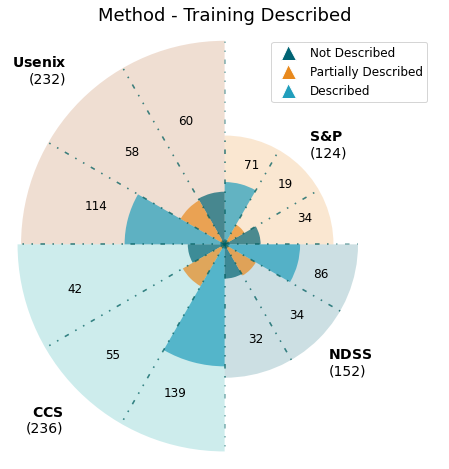

In [4]:
######## FIGURE 3 #########


### Polar Coordinate ###
df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df['Training Described'].isna()]
df['Training Described'] = df['Training Described'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette is "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette is "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices 
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    return x
df_temp = df.copy()
df_temp["Training Described"] = df_temp["Training Described"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Training Described"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique()) 
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2

small_colors = np.tile(small_palette,4)

# Scale small boxes so we can see them
ave = 35#np.mean(small_radi)

small_radi_mod = [s if s > ave else s + 0.2*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge') 

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]), 
            verticalalignment=alignments[c][0], 
            horizontalalignment=alignments[c][1],
            fontsize=14
           )
    
## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='Not Described',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Partially Described',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Described',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Method - Training Described",
    fontsize=18
)

plt.savefig("Figure3.pdf",bbox_inches='tight')







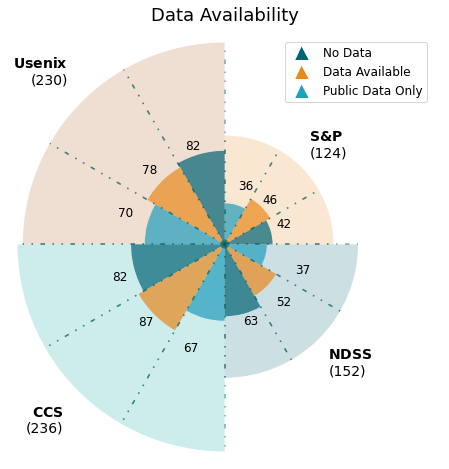

In [5]:
###### FIGURE 4 ########


### Polar Coordinate ###
df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]

df = df[~df.Data_Available.isna()]
df['Data_Available'] = df['Data_Available'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette is "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette is "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices 
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only

def convert_label(x):
    if x == -1:
        return 0
    elif x == 0:
        return 0
    elif x == 4:
        return 2
    elif x>0 & x<4:
        return 1
    elif x == 8:
        return 0
    elif x>4 & x <8:
        return 1
    else:
        return 2
df_temp = df.copy()
df_temp["Data_Available"] = df_temp["Data_Available"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Data_Available"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique()) 
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2


small_colors = np.tile(small_palette,4)
# Scale small boxes so we can see them

small_radi_mod = 1.3*(small_radi)
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge') 

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]), 
            verticalalignment=alignments[c][0], 
            horizontalalignment=alignments[c][1],
            fontsize=14
           )
    
## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='No Data',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Data Available',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Public Data Only',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Data Availability",
    fontsize=18
)

plt.savefig("Figure4.pdf",bbox_inches='tight')






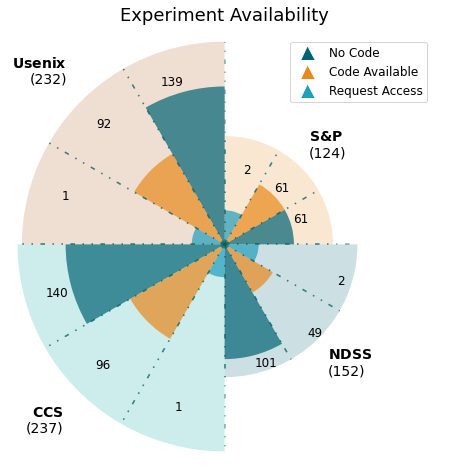

In [6]:
######### FIGURE 5 #########


### Polar Coordinate ###
df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]
df = df[~df.Available.isna()]
df['Available'] = df['Available'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping

df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")


conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices 


# we will shrink the codes into 0 - no code, 1 - code there, 2 - available in future but never posted,
# 3 - request access
# For now just going off 0 and 1


def convert_label(x):
    if x == -1:
        return 0
    elif x >2 and x < 7:
        return 1
    elif x==2:
        return 0
    elif x==8:
        return 0
    elif x== 7:
        return 2
    else:
        return x
df_temp = df.copy()
df_temp["Available"] = df_temp["Available"].apply(convert_label)
df_group = df_temp.groupby(["Conference","Available"]).size()

# build the initial offsets
slice_len = 3 ###len(df_group.Available.unique()) 
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]*inner_radius_modify
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2


small_colors = np.tile(small_palette,4)
# Scale small boxes so we can see them
ave = np.mean(small_radi)

small_radi_mod = [s if s > 0.5*ave else s + 0.45*ave for s in small_radi ]
ax.bar(small_angle,small_radi_mod, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge') 

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]), 
            verticalalignment=alignments[c][0], 
            horizontalalignment=alignments[c][1],
            fontsize=14
           )
    
## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r/inner_radius_modify),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*np.square(inner_text_radius+0.05), "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='No Code',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Code Available',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Request Access',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 12})
#TITLE
ax.set_title(
    "Experiment Availability",
    fontsize=18
)

plt.savefig("Figure5.pdf",bbox_inches='tight')




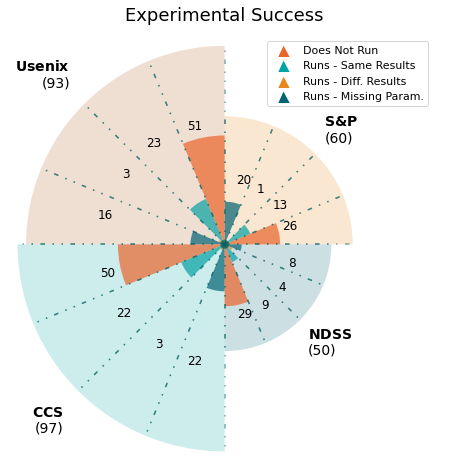

In [7]:
####### FIGURE 6 ##########

### Polar Coordinate ###
df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]
df.to_csv("sheet1.csv")

## need to add a conversion for df['available'] larger then

df = df[~df['Runs'].isna()]
def get_tools(ava, run):
    
    if ava >2 and ava < 7:
        if run == -1:
            return 1
        else:
            return run
    else:
        return run

df['Runs'] = df.apply(lambda x: get_tools(x['Available'],x['Runs']), axis=1)
df['Runs'] = df['Runs'].astype(int)
#map for polar coordinates
# of the conferences
coord_dict = {
    'S&P': 0,
    'Usenix': np.pi/2,
    'CCS': np.pi,
    'NDSS': 3*np.pi/2
}
confs = coord_dict.keys()
# create table grouping
df = df[df.Runs>-1]
df_conf_radi = df.groupby(["Conference"]).size()
df_width = np.pi/2*np.ones(4)

# May have to adjust the radius for this
conf_radi = [df_conf_radi[a] for a in confs]

#
# ax.axis("off")
palette = 'orangeblue'
if palette is "blue":
    conf_colors_dict = {
        'S&P':'steelblue' ,
        'Usenix': 'skyblue',
        'CCS': 'paleturquoise',
        'NDSS': 'cornflowerblue'
    }
elif palette is "orangeblue":
    conf_colors_dict = {
        'S&P':'#E8891D' ,
        'Usenix': '#B35A20',
        'CCS': '#05a3a4',
        'NDSS': '#006373'
    }

conf_colors = [conf_colors_dict[a] for a in confs]
plt.rcParams["figure.figsize"] = (8,8)
ax = plt.subplot(projection='polar')
ax.spines['polar'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
ax.bar(coord_dict.values(),conf_radi, color=conf_colors,width=df_width, bottom=0.0, alpha=0.2, align='edge')


## Making the small slices 
# -1: Not Applicable
# 0: Dataset Unavailable
# 1: Dataset is linked
# 2: Request Access
# 3: Multiple Datasets unavailable, some are
# 4: Public Only
# 5: Dataset Offered in Future
# 6: Incomplete Single Dataset
# 7: Processed Data in Repository
# 8: Broken Link
#Converting Data Labels
# 0 - Not available
# 1 - Available in some form
# 2 - Public datasets only


df_temp = df.copy()
df_group = df_temp.groupby(["Conference","Runs"]).size()

# build the initial offsets
slice_len = 4
small_radi = np.zeros(4*slice_len)
angle = np.linspace(0, np.pi/2, slice_len, endpoint=False)
small_angle = np.ones(4*slice_len)
small_width = np.ones(4*slice_len)*np.pi/2/slice_len
for i,c in enumerate(confs):
    for d in df_group[c].keys():
        small_radi[i*slice_len + d] = df_group[c][d]
    for d in range(slice_len):
        small_angle[i*slice_len +d] = angle[d]+i*np.pi/2
if palette is 'blue':
    small_palette = [
        'mediumaquamarine',
        'royalblue',
        'mediumpurple'
    ]
elif palette is 'orangeblue':
    small_palette = [
        '#006373',
        
        '#E8891D',
        '#05A3A4',
        '#EA652C'
        
        
        
    ]
small_palette = np.flip(small_palette)
    
small_colors = np.tile(small_palette,4)
ax.bar(small_angle,small_radi, width=small_width,color=small_colors, bottom=0.0, alpha=0.7, align='edge') 

## LABELS

#Conference labels
#label_rad = max(conf_radi)*1.4 ## we will have to fix this, but works for now
alignments = {
    'S&P':['bottom','left' ],
    'Usenix': ['bottom','right' ],
    'CCS': ['top','right' ],
    'NDSS':['top','left' ]
}
for c in confs:
    ax.text(coord_dict[c]+np.pi/4,df_conf_radi[c]*1.1,r"$\bf{" + c + "}$"+"\n({})".format(df_conf_radi[c]), 
            verticalalignment=alignments[c][0], 
            horizontalalignment=alignments[c][1],
            fontsize=14
           )
    
## Paper labels
lines_theta=[]
lines_rad = []
small_label_size = 12
for r, a,c in zip(small_radi,small_angle,np.repeat(list(confs),slice_len)):
    #Labels
    if r >2:
        ax.text(a+small_width[0]/2, max(df_group[c])*1.05, "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    else:
        ax.text(a+small_width[0]/2, max(df_group[c])*1.05, "{:.0f}".format(r),
               verticalalignment=alignments[c][0], 
               horizontalalignment=alignments[c][1],
               fontsize=small_label_size)
    #Dotted Line
    # first one
    d_theta = [a,a]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
    # second one
    d_theta = [a+small_width[0],a+small_width[0]]
    lines_theta.append(d_theta)
    d_rad = [0,df_conf_radi[c]]
    lines_rad.append(d_rad)
## dotted lines
for dl in range(len(lines_theta)):
    ax.plot(lines_theta[dl],lines_rad[dl],linestyle=(0, (3, 5, 1, 5, 1, 5)), color='#005F60',alpha=0.5)

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[0],label='Does Not Run',
        markersize=13
    ),
    # Code
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[1],label='Runs - Same Results',
        markersize=13
    ),
    # Request Access
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[2],label='Runs - Diff. Results',
        markersize=13
    ),
    Line2D (
        [0],[0], marker='^',color='w',markerfacecolor=small_palette[3],label='Runs - Missing Param.',
        markersize=13
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.98,0.98),prop={'size': 11})
#TITLE
ax.set_title(
    "Experimental Success",
    fontsize=18
)

plt.savefig("Figure6.pdf",bbox_inches='tight')








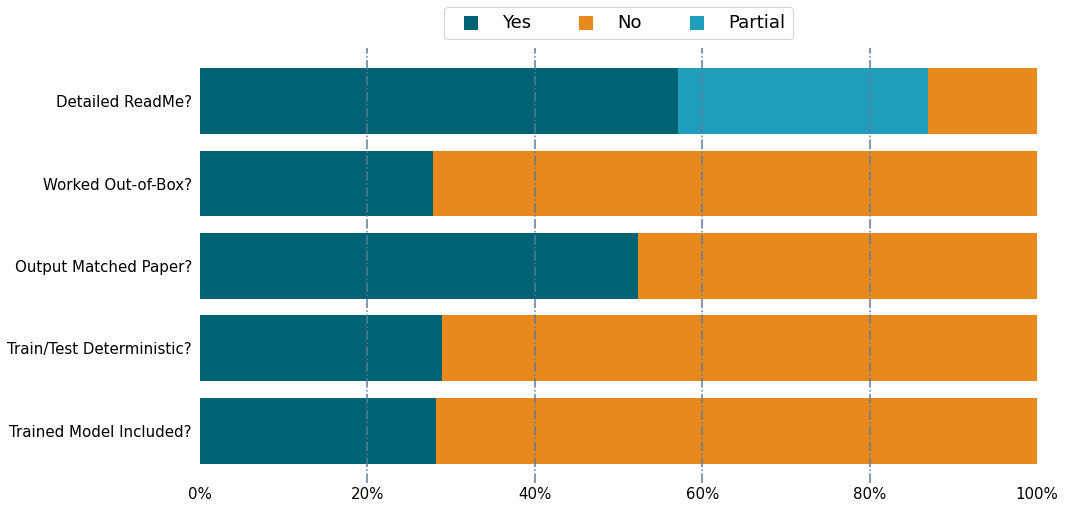

In [8]:
###### FIGURE 7 ########

df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]
df = df[~df['Available'].isna()]
small_palette = [
    '#006373',
    '#E8891D',
    '#219ebc',
    '#05A3A4',
    '#EA652C'
]

plt.rcParams["figure.figsize"] = (15,8)
ax = plt.subplot()

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlim(0,100)

 

def convert_label(x):
    if x == -1:
        return 0
    elif x >2 and x < 7:
        return 1
    elif x==8:
        return 0
    elif x== 7:
        return 0
    elif x ==2:
        return 0
    else:
        return x
df["Available"] = df["Available"].apply(convert_label)

def move_outliers(x):
    if x!= 1:
        return 0
    else:
        return 1
import math
def move_readme(x):
    if math.isnan(x):
        return 0
    if x == -1:
        return 0
    else:
        return x
#We are creating the out-of-box, output, train-test, trained model, readme graph
oob = df[df['Available']==1]['Out-of-box'].apply(move_outliers)
df_out = sum(oob)/len(oob)
output = df[df['Available']==1]['Output'].apply(move_outliers)
df_output = sum(output)/len(output)
tt = df[df['Available']==1]['Train/test'].apply(move_outliers)
df_tt = sum(tt)/len(tt)
trmod = df[df['Available']==1]['TrainedModel'].apply(move_outliers)
df_trmod = sum(trmod)/len(trmod)
readme = df[df['Available']==1]['ReadMe'].apply(move_readme)
rm ,rm_counts = np.unique(readme, return_counts=True)
rm_percent = rm_counts/len(readme)

x = ['Detailed ReadMe? ','Worked Out-of-Box? ', 'Output Matched Paper? ', 'Train/Test Deterministic? ', 'Trained Model Included? ']
y = [df_out,df_output, df_tt, df_trmod]
col = [small_palette[0],small_palette[1],small_palette[2]]
ax.barh(x[::-1],np.zeros(len(x)))
box_coord_dict = dict()

for factor,val in zip(x[::-1],y):
    box_coord_dict[factor] = [val, 1-val]
box_coord_dict['Detailed ReadMe? '] = rm_percent[::-1]
for k in box_coord_dict.keys():
    tot = 0
    count = 0
    for v in box_coord_dict[k]:
        ax.barh([k],v,left=tot,color = col[count])
        if k == 'Detailed ReadMe? ':
            col_n = [0,2,1]
            ax.barh([k],v*100,left=tot,color = col[col_n[count]])
        else:
            ax.barh([k],v*100,left=tot,color = col[count])
        tot += v*100
        count+=1


# ##Create Custom Legend
legend_elements = [
    # No Code
        Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[0],label='Yes',
        markersize=15
    ),
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[1],label='No',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[2],label='Partial',
        markersize=15
    ),
    # Request Access

]

ax.legend(handles=legend_elements, loc='lower center',bbox_to_anchor=(0.5,1.0),prop={'size': 18}, ncol=3)
col ='#5b7c99'


for a in range(1,5):
    ax.axvline(a*20, linestyle='dashdot',color=col)


ax.tick_params(axis ='both', which ='both', length = 0,labelsize=15)
ax.set_xlabel('', fontsize=20)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig("Figure7.pdf",bbox_inches='tight')

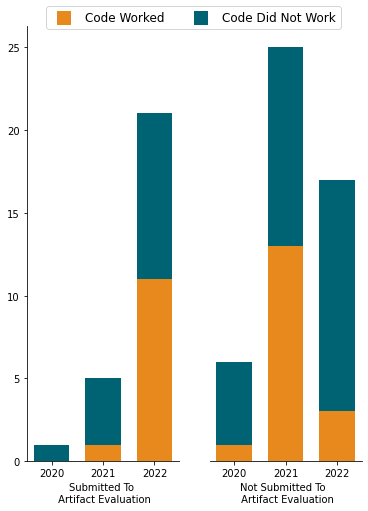

In [11]:
###### FIGURE 8 ######
df = pd.read_csv('artifact.csv')

doesNotRunDictSubmitted = {2020:0,2021:0,2022:0}
runsDictSubmitted = {2020:0,2021:0,2022:0}

doesNotRunDictNot = {2020:0,2021:0,2022:0}
runsDictNot = {2020:0,2021:0,2022:0}

for i in range(len(df['Paper Title'])):
    year = df['Year'][i]
    runs = df['Code Runs'][i]

    if pd.notna(year):
        year = int(year)
        runs = int(runs)
        hasCode = df['Has Code?'][i]
        if hasCode != 0:
            if df['Has artifact?'][i]==1:
                if runs==1 or runs==3:
                    runsDictSubmitted[year] += 1
                else:
                    doesNotRunDictSubmitted[year] += 1
            else:
                if runs==1 or runs==3:
                    runsDictNot[year] += 1
                else:
                    doesNotRunDictNot[year] += 1

# print(doesNotRunDictSubmitted)
# print(runsDictSubmitted)
# print(doesNotRunDictNot)
# print(runsDictNot)

doesNotRunSubmitted = []
runsSubmitted = []
doesNotRunNot = []
runsNot = []
for key in doesNotRunDictSubmitted.keys():
    doesNotRunSubmitted.append(doesNotRunDictSubmitted[key])
for key in runsDictSubmitted.keys():
    runsSubmitted.append(runsDictSubmitted[key])
for key in doesNotRunDictNot.keys():
    doesNotRunNot.append(doesNotRunDictNot[key])
for key in runsDictNot.keys():
    runsNot.append(runsDictNot[key])

years = ['2020','2021','2022']
width = 0.69
orange = small_palette[1]
blue = small_palette[0]

plt.rcParams["figure.figsize"] = (6,8)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(years, runsSubmitted, width, color=orange)
ax1.bar(years, doesNotRunSubmitted, width,
             bottom=runsSubmitted, color=blue)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set(xlabel="Submitted To \n Artifact Evaluation")

ax2.bar(years, runsNot, width, color=orange)
ax2.bar(years, doesNotRunNot, width,
             bottom=runsNot, color=blue)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='y', which='both', left=False)
ax2.set(xlabel="Not Submitted To  \n Artifact Evaluation")

##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[1],label='Code Worked',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[0],label='Code Did Not Work',
        markersize=15
    ),
]

ax2.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(0.9,1.06),prop={'size': 12},ncol=2)
plt.savefig("AEC_fig.pdf",bbox_inches='tight')




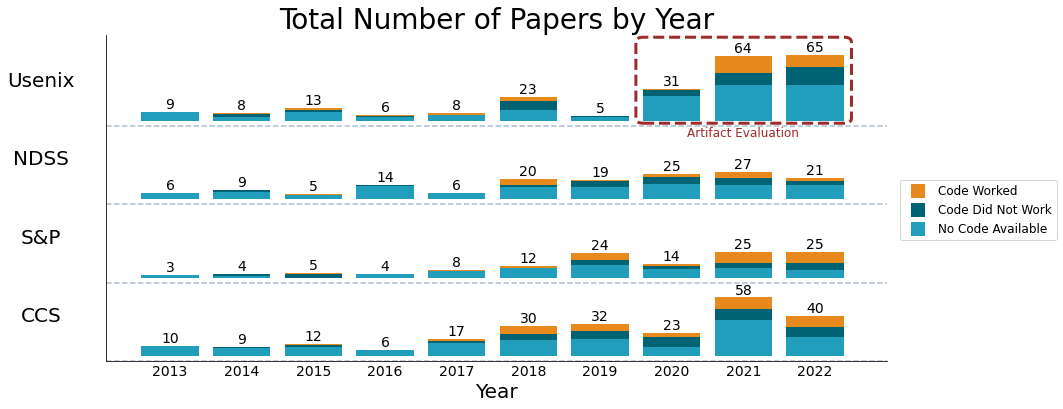

In [10]:
##### FIGURE 9 #######

df = pd.read_csv("sheet1.csv")
# clean conference
conf_dict = {
    "IEEE":"S&P",
    "USEN":"Usenix",
    "ACM": "CCS",
    "NDSS":"NDSS",
    "CCS":"CCS",
    "S&P":"S&P",
    "Usenix":"Usenix"
}
    
df["Conference"] = [conf_dict[c.upper()[0:4].strip()] for c in df["Conference"]]
small_palette = [
    '#006373',
    '#E8891D',
    '#219ebc',
    '#05A3A4',
    '#EA652C'
]
# small_palette = np.flip(small_palette)
# df = df[~df['Runs'].isna()]
# df['Runs'] = df['Runs'].astype(int)

## Define our subplots
# fig, axs = plt.subplots(4,10, sharex=True, sharey=True)
# fig
plt.rcParams["figure.figsize"] = (14,6)
ax = plt.subplot()
# years = [i for i in range(2013,2023)]

ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.set_yticks([])
offset = 5
ylim = 310
total_ylim = offset + ylim
ax.set_ylim(0,total_ylim+7)
col ='#5b7c99'
col1 = '#5b7c99'
colred ='#9e2a2b'

# Define conference offsets
bottom_offset = {
    'S&P':ylim/4 + offset,
    'CCS': 0*ylim*3/4+offset,
    'Usenix': ylim*3/4+offset,
    'NDSS':ylim*1/2 +offset
}
ax.add_patch(FancyBboxPatch((2019.5, bottom_offset['Usenix']-offset/2), 3.01, ylim/4+offset/2+5,
                            linestyle='--',
                            boxstyle="round,pad=-0.001,rounding_size=.1",
                            fc='none',lw='3',
                            mutation_aspect=50,color=colred
                           ) )


df_group = df.groupby(['Conference','Year','Runs']).size()
curr_year = 0
bottom = 0
def color_ind(num):
    if num < 0:
        return 2
    elif num > 0:
        return 1
    else:
        return 0
# for c in df_group['Conference'].unique():
text_coord_dict = dict()
for a in df_group.keys():
    if curr_year != a[1]:
        if curr_year != 0:
            text_coord_dict[(curr_year,bottom)] = curr_sum
        curr_sum = 0
        bottom = bottom_offset[a[0]]
        curr_year = a[1]
    color = small_palette[color_ind(a[2])]
    ax.bar([a[1]],[df_group[a]],bottom=[bottom], color=color)
    
    curr_sum+=df_group[a]
    bottom+= df_group[a]
text_coord_dict[(curr_year,bottom)] = curr_sum


small_label_size=14
for text_coord in text_coord_dict.keys():
    ax.text(text_coord[0],text_coord[1],"{:.0f}".format(text_coord_dict[text_coord]), 
            verticalalignment='bottom', 
               horizontalalignment='center',
               fontsize=small_label_size)

    
## Grey lines time

for k in bottom_offset.keys():
    ax.axhline(bottom_offset[k]-5,color=col, linestyle='--', alpha=0.5)
##Create Custom Legend
legend_elements = [
    # No Code
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[1],label='Code Worked',
        markersize=15
    ),
    # Code
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[0],label='Code Did Not Work',
        markersize=15
    ),
    # Request Access
    Line2D (
        [0],[0], marker='s',color='w',markerfacecolor=small_palette[2],label='No Code Available',
        markersize=15
    ),
]

ax.legend(handles=legend_elements, loc='upper right',bbox_to_anchor=(1.225,0.575),prop={'size': 12})

  
### need to calculate this correctly
for c in bottom_offset.keys():
    ax.text(2011.2, bottom_offset[c]+ylim/8-5, c, fontsize=20,
           horizontalalignment='center')
ax.text(2021,bottom_offset['Usenix']-offset-1,"Artifact Evaluation", 
            verticalalignment='top', 
               horizontalalignment='center',
               fontsize=small_label_size-2, color = colred)

## Possibly add a total column


ax.tick_params(axis ='both', which ='both', length = 0)
ax.set_xlabel('Year', fontsize=20)
ax.set_title('Total Number of Papers by Year',fontsize=28)
xticks = [y for y in range(2013,2023)]
# xticks.append('Conference Total')
# xticks.append('Totals')
plt.xticks(xticks, fontsize=small_label_size)
plt.savefig("Figure9.pdf",bbox_inches='tight')